<h1 align='center'><font color='orange'>Bike Sharing Demand Prediction</font></h1>
<h3 align='center'><font color='orange'><i>A Machine Learning approach to forecast Bike Rental Demand</i></font></h3>
<h2 align='center'><font color='orange'>Part 3 - Modelling</font></h2>

## To try out the project, [click here...](https://bike-demand-prediction.herokuapp.com/)

#### -> To check out Part 1 (Exploratory Data Analysis), [click here](https://nbviewer.jupyter.org/github/SarthakRana/Bike-Sharing-Demand-Prediction/blob/main/Bike_Sharing_EDA_Part1.ipynb)
#### ->To check out Part 2 (Data Preparation), [click here](https://nbviewer.jupyter.org/github/SarthakRana/Bike-Sharing-Demand-Prediction/blob/main/bike_sharing_data_preparation_Part2.ipynb)

<h1 align='center'><img src="https://knowledge.wharton.upenn.edu/wp-content/uploads/2017/09/092817_chinabikeshare.jpg"></h1>

# Quick Navigation
* [1. Introduction](#1)
* [2. Evaluation Metric](#2)
* [3. Importing and defining the necessities](#3)
    * [3.1 Importing relevant libraries](#4)
    * [3.2 Importing data](#5)
    * [3.3 Splitting data into train and test set](#6)
    * [3.4 Defining RMSLE](#7)
* [4. Modelling + Training](#8)
    * [4.1 Finding out the most suitable model for the problem](#9)
    * [4.2 Approach #1](#10)
        * [4.2.1 Modelling with best parameters](#11)
        * [4.2.2 Saving model](#12)
        * [4.2.3 Prediction + Submission(for Kaggle only)](#13)
    * [4.3 Approach #2](#14)
        * [4.3.1 Training with reduced features and best parameters](#15)
        * [4.3.2 Saving model](#16)
        * [4.3.3 Prediction + Submission(for Kaggle only](#17)

<a id='1'></a>
# 1. Introduction
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

<a id='2'></a>
# 2. Evaluation Metric :

The Root Mean Squared Log Error (RMSLE) can be defined using a slight modification on sklearn's `mean_squared_log_error` function, which itself is a modification on the familiar `Mean Squared Error (MSE)` metric.

The formula for RMSLE is represented as follows:

RMSLE = $\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Where:

=> $n$ is the total number of observations in the (public/private) data set,

=> $p_i$ is your prediction of target, and

=> $a_i$ is the actual target for $i$.

=> $log(x)$ is the natural logarithm of $x$ ($log_e(x)$.

Yo can read more about the Evaluation Metric here : https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation

<a id='3'></a>
# 3. Importing and defining the necessities

<a id='4'></a>
## 3.1 Importing relevant libraries

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

import pickle

# SEED EVERYRHING - to get reproducable results
np.random.seed(42)

<a id='5'></a>
## 3.2 Importing data 

In [2]:
train_df = pd.read_csv('train_processed.csv')
# test_df = pd.read_csv('../input/bike-demand-processed-data/test_processed.csv')

In [3]:
train_df.sample(5)

,hour,month,holiday,workingday,temp,humidity,windspeed,season_summer,season_fall,season_winter,weather_mist,weather_light_rain,weather_heavy_rain,count
5361,-0.065537,1.588929,-0.173424,-1.446595,-1.102581,-0.892925,1.128976,-0.575495,-0.573022,1.724122,1.679458,-0.295519,-0.009721,209
4982,0.652753,1.588929,-0.173424,0.691279,-0.470290,-1.152947,0.027279,-0.575495,-0.573022,1.724122,-0.595430,-0.295519,-0.009721,201
9610,1.227385,1.011737,-0.173424,0.691279,0.162001,0.511194,1.618346,-0.575495,-0.573022,1.724122,1.679458,-0.295519,-0.009721,256
8153,-1.358459,0.145948,-0.173424,0.691279,1.426584,-0.008850,-0.462090,-0.575495,1.745133,-0.580005,-0.595430,-0.295519,-0.009721,17
4098,1.083727,1.011737,-0.173424,-1.446595,-0.575672,0.719212,-0.216996,-0.575495,-0.573022,1.724122,1.679458,-0.295519,-0.009721,162


In [4]:
cols = [x for x in train_df.columns if x!='count']
cols

['hour',
 'month',
 'holiday',
 'workingday',
 'temp',
 'humidity',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'weather_mist',
 'weather_light_rain',
 'weather_heavy_rain']

<a id='6'></a>
## 3.3 Spliting data into training and validation set

In [5]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id='7'></a>
## 3.4 Defining RMSLE

Lower the value, better is the model performance.

In [6]:
def rmsle(y_pred, y_val):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y_pred]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_val]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

<a id='8'></a>
# 4. Modelling + Training

<a id='9'></a>
## 4.1 Finding out the most suitable model for the problem

### Let's start by directly training each model with data and getting there predictions and performance just to get rough idea of how differnt kind of models perform on our dataset.

In [7]:
'''Creating instance for each Regression type'''
lr_reg = LinearRegression()
poly = PolynomialFeatures(degree=2)
lin_reg = LinearRegression()
svr_reg = SVR()
dt_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)
lasso_reg = Lasso(random_state=42)
ridge_reg = Ridge(random_state=42)
extra_reg = ExtraTreesRegressor(random_state=42)

'''Fitting each model on train data'''
# Linear Regression
lr_reg.fit(X_train, y_train)
# Polynomial Regression
X_poly = poly.fit_transform(X_train)
lin_reg.fit(X_poly, y_train)
# SVR
svr_reg.fit(X_train, y_train)
# Decision Tree
dt_reg.fit(X_train, y_train)
# Random Forest
rf_reg.fit(X_train, y_train)
# XGBoost
xgb_reg.fit(X_train, y_train)
# Gradient Boosting
gb_reg.fit(X_train, y_train)
# Lasso Regression
lasso_reg.fit(X_train, y_train)
# Ridge Regression
ridge_reg.fit(X_train, y_train)
# Extra Trees Regression
extra_reg.fit(X_train, y_train)

'''Predicitons'''
y_preds_lr = lr_reg.predict(X_test)
y_preds_poly = lin_reg.predict(poly.transform(X_test))
y_preds_svr = svr_reg.predict(X_test)
y_preds_dt = dt_reg.predict(X_test)
y_pred_rf = rf_reg.predict(X_test)
y_preds_xgb = xgb_reg.predict(X_test)
y_pred_gb = gb_reg.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_extra = extra_reg.predict(X_test)


'''Computing the RMSLE'''
lr_rmsle = rmsle(y_preds_lr, y_test)
poly_rmsle = rmsle(y_preds_poly, y_test)
svr_rmsle = rmsle(y_preds_svr, y_test)
dt_rmsle = rmsle(y_preds_dt, y_test)
rf_rmsle = rmsle(y_pred_rf, y_test)
xgb_rmsle = rmsle(y_preds_xgb, y_test)
gb_rmsle = rmsle(y_pred_gb, y_test)
lasso_rmsle = rmsle(y_pred_lasso, y_test)
ridge_rmsle = rmsle(y_pred_ridge, y_test)
extra_rmsle = rmsle(y_pred_extra, y_test)

perf_df = pd.DataFrame({"Regression Models" : ['Linear', 'Polynomial', 'Support Vector Machine',
                                    'Decision Tree', 'Random Forest', 'XGBoost', 'Gradient Boosting', 
                                    'Lasso', 'Ridge', 'Extra Tree'
                                   ], 
                        "RMSLE score" : [lr_rmsle, poly_rmsle, svr_rmsle, dt_rmsle, rf_rmsle, xgb_rmsle,
                                         gb_rmsle, lasso_rmsle, ridge_rmsle, extra_rmsle]
                       })

Let's see the RMSLE scores of each model: 

In [8]:
perf_df['RMSLE score'] = perf_df['RMSLE score'].apply(lambda x : round(x,5))
perf_df.sort_values("RMSLE score", ascending=True)

,Regression Models,RMSLE score
9,Extra Tree,0.42498
4,Random Forest,0.42768
3,Decision Tree,0.53458
5,XGBoost,0.57619
6,Gradient Boosting,0.75383
2,Support Vector Machine,1.01811
7,Lasso,1.20134
8,Ridge,1.20944
0,Linear,1.20999
1,Polynomial,1.38460


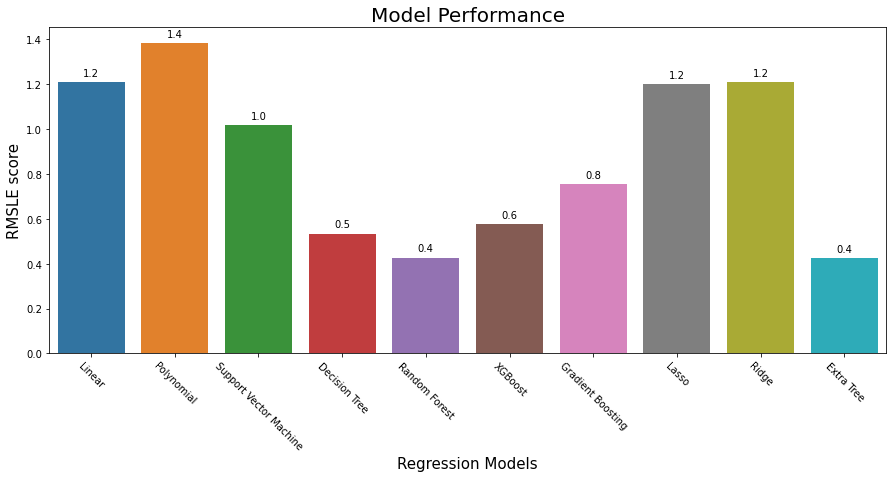

In [9]:
plt.figure(figsize=(15,6))
plt.title("Model Performance", fontsize=20)
plt.xlabel("Models", fontsize=15)
plt.ylabel("RMSLE Score", fontsize=15)
splot = sns.barplot(perf_df['Regression Models'], perf_df['RMSLE score'])
# Annotate the bars in plot
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
plt.xticks(rotation=-45)
plt.show()

### We can see that Tree based Ensemble algorithms like Random Forest and Extra Trees are performing quite well as compared to other models. Moving forward, <u>I will be working with Random Forest algorithm.</u>

### Model performance can further be improved using most appropriate model hyperparameters which can be found using optimization technique like <u>Hyperparameter Tuning</u>. 

### I will be using <u>Randomized Search CV</u> method with a CV of 5 for 100 combinations to find optimal set of hyperparameters.

<a id='10'></a>
## 4.2 Approach #1

<a id='11'></a>
### 4.2.1 Modelling with best parameters

In [10]:
# Parameters to search on
param_dist = {
    "n_estimators" : [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    "max_features" : ["auto", "sqrt", "log2"],
    "max_depth" : [int(x) for x in np.linspace(start=10, stop=100, num=10)],
    "min_samples_split" : [1,2,3,4,5,6,7,8,9,10],
    "min_samples_leaf" : [1,2,3,4,5],
    "bootstrap" : [True, False]
}
pprint(param_dist)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [11]:
# Search across 100 different combinations of parameters
rf_model = RandomForestRegressor()
# Create the RandomizedSearchCV instance
rscv = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, n_jobs=-1,
                         cv=5, verbose=2, random_state=42)
# Fit the random search model
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 94.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 126.1min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [12]:
# Best Parameters for our model
best_params_df = pd.DataFrame({"Parameters" : rscv.best_params_.keys(),
                               "Best Values" : rscv.best_params_.values()
                              })
best_params_df

,Parameters,Best Values
0,"(n_estimators, min_samples_split, min_samples_...","(1200, 6, 1, auto, 80, True)"
1,"(n_estimators, min_samples_split, min_samples_...","(1200, 6, 1, auto, 80, True)"
2,"(n_estimators, min_samples_split, min_samples_...","(1200, 6, 1, auto, 80, True)"
3,"(n_estimators, min_samples_split, min_samples_...","(1200, 6, 1, auto, 80, True)"
4,"(n_estimators, min_samples_split, min_samples_...","(1200, 6, 1, auto, 80, True)"
5,"(n_estimators, min_samples_split, min_samples_...","(1200, 6, 1, auto, 80, True)"


### Let's train our Random Forest Model again with above best parameters and see if there is any improvement.

### I will also use KFold cross validation to validate the model.

In [13]:
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=42, shuffle=True)

In [14]:
# Fitting model with best parameters
rmsle_scores_list = []
models_list = []

# Converting training data to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
    print("FOLD {}".format(fold+1))
    
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]
    
    model_app_1 = RandomForestRegressor(n_estimators=1200,
                                     min_samples_split=6,
                                     min_samples_leaf=1,
                                     max_features='auto',
                                     max_depth=80,
                                     bootstrap=True
                                    )
    model_app_1.fit(X_tr, y_tr)
    
    # Validation score 
    val_predictions = model_app_1.predict(X_val)
    rmsle_score = rmsle(val_predictions, y_val)
    print("RMSE validation Score : {}\n".format(rmsle_score))
    rmsle_scores_list.append(rmsle_score)
    models_list.append(model_app_1)

FOLD 1
RMSE validation Score : 0.4599207012000358

FOLD 2
RMSE validation Score : 0.43100801848228204

FOLD 3
RMSE validation Score : 0.43592514500373875

FOLD 4
RMSE validation Score : 0.42319595507986324

FOLD 5
RMSE validation Score : 0.4176025380807097



In [15]:
# Getting best model and its RMSLE
best_rmsle_idx = np.argmin(rmsle_scores_list)
print("RMSLE score after parameter tuninig : {:.5f}".format(rmsle_scores_list[best_rmsle_idx]))

# Getting the best model
best_model_app1 = models_list[best_rmsle_idx]

RMSLE score after parameter tuninig : 0.41760


#### *Old RMSE score = 0.42768*<br>
#### *RMSE score after hyperparameter tuning = 0.41760*

### There is an improvement of ~0.01 in the RMSLE score. This is not much but atleast it is an improvement which is a good sign :)

In [16]:
# predictions
y_preds_app1 = best_model_app1.predict(X_test)

# Computing the RMSLE with test data
test_rmsle = rmsle(y_preds_app1, y_test)
print("RMSLE value with test data : {:.4f}".format(test_rmsle))

RMSLE value with test data : 0.4324


### Let's check how closely our model has predicted the values to the actual ones 

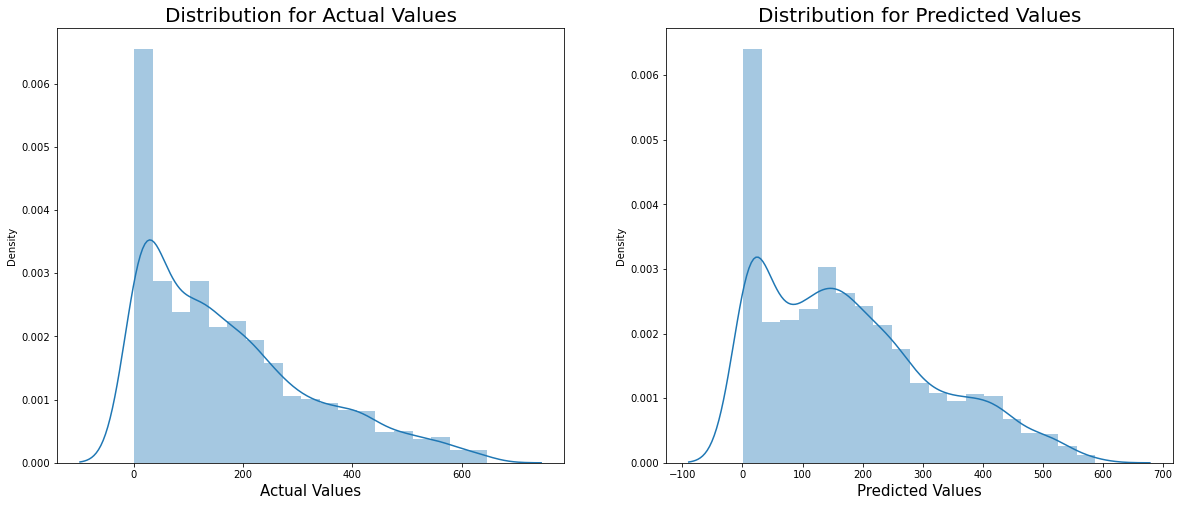

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title("Distribution for Actual Values", fontsize=20)
sns.distplot(y_test, ax=ax[0])
ax[0].set_xlabel("Actual Values", fontsize=15)

ax[1].set_title("Distribution for Predicted Values", fontsize=20)
sns.distplot(y_preds_app1, ax=ax[1])
ax[1].set_xlabel("Predicted Values", fontsize=15)

plt.show()

### We can confirm visually that our predictions are pretty close to the actual values and our model has performed well.

<a id='12'></a>
### 4.2.2 Save model

In [18]:
pickle.dump(best_model_app1, open('model_approach_1.pkl', 'wb'))

<a id='13'></a>
### 4.2.3 Prediction + Submission (for Kaggle only)

In [ ]:
# predict on test data
y_preds = best_model_app_1.predict(test_df)

# convert to dataframe
y_preds_df = pd.DataFrame({'count' : y_preds})

# Extract datetime column values in a dataframe
datetime_df = pd.DataFrame(pd.read_csv('../input/bike-demand-processed-data/test.csv')['datetime'])

# Combine the 2 dataframes
subm = pd.concat([datetime_df, y_preds_df], axis=1)
subm.head()

# Convert to csv file
subm.to_csv('sampleSubmission.csv', index=False)

<a id='14'></a>
## 4.3 Approach #2

### In this section, we will try to look at the feature importances and select only those features which have a good contribution towards the model performance. So let's look into it and eliminate the irrelevant ones. Right feature selection will:
* Improve model accuracy.
* Decrease the error value.
* Increase training speed.

**To perform Feature Selection, we will use the following techniques:**
1. Feature Importance.
2. Recursive Feature Elimination (RFE).

In [30]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

<BarContainer object of 13 artists>

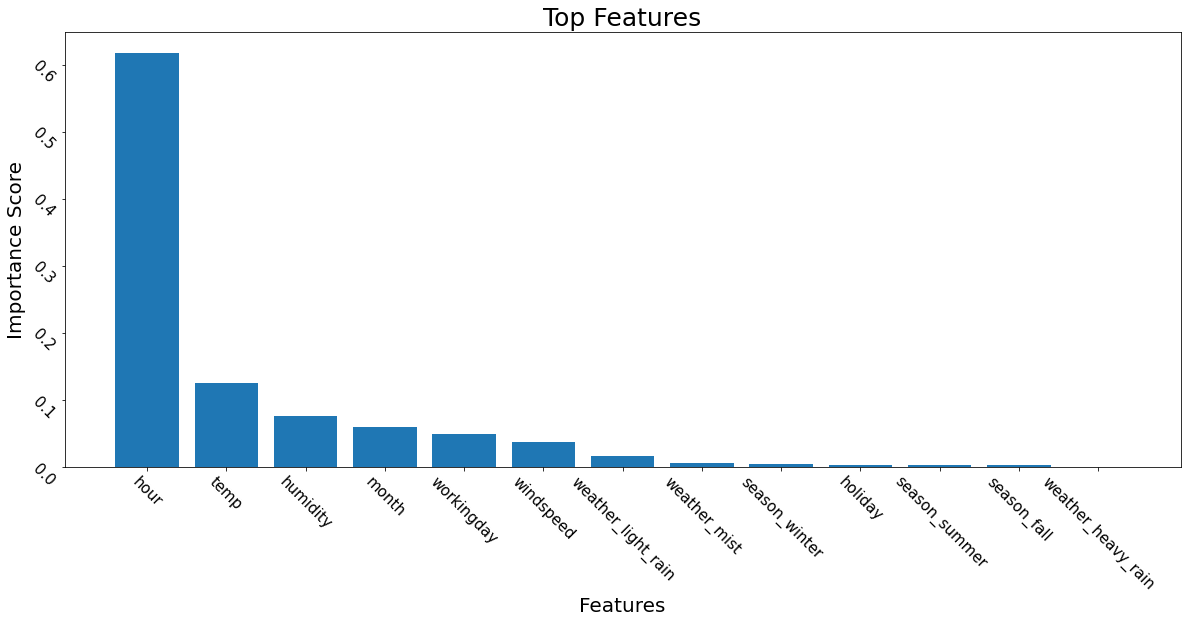

In [32]:
'''
FEATURE IMPORTANCE METHOD :-

Here we will make use of feature_importances_ attribute of Random Forest to look at 
which features did our model considered the most important.
'''
plt.figure(figsize=(20, 8))
plt.title("Top Features", fontsize=25)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Importance Score", fontsize=20)
plt.xticks(rotation=-45, fontsize=15)
plt.yticks(rotation=-45, fontsize=15)
feat_importances = pd.Series(model.feature_importances_, index= cols)
feat_importances = feat_importances.sort_values(ascending=False)
plt.bar(feat_importances.index, feat_importances)

The Feature importance attribute gives us which feature is how much important in terms of score but it <u>doesn't tell us about the optimal number of features</u> to select. We selected the number "13" at random.

To get the optimal number of features to be selected, we use Recursive Feature Elimination (RFE). <u>RFE is compute intensive but is a very robust method to select features with great accuracy</u> as the process is iterative. 

In [33]:
'''
RECURSIVE FEATURE ELIMINATION (RFE)

Here, we make use of for loop to iterate over different number of features and store model scores with that 
many number of features in each iteration. Number of feature corresponding to best model score will be chosen
as the selected features for final training.
'''
start = time.time()
nof = 0
high_score = 0
scores = []
nb_features = X_train.shape[1]
for i in range(nb_features):
    print("Iteration :", i+1)
    model = RandomForestRegressor()
    rfe = RFE(estimator=model, n_features_to_select=i+1)
    X_train_rfe = rfe.fit_transform(X_train, y_train) # this returns selected features in train data 
    X_test_rfe = rfe.transform(X_test) # this returns selected features in validation data
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    scores.append(score)
    if score > high_score:
        high_score = score
        nof = i+1
        print("High Score :", high_score)
        print("Number of features :", nof)

print("Optimal number of features :", nof)
print("Total execution time for RFE : " +  str(round((time.time() - start)/60, 4)) + " minutes.")

Iteration : 1
High Score : 0.4785776039043331
Number of features : 1
Iteration : 2
High Score : 0.5581965407771791
Number of features : 2
Iteration : 3
Iteration : 4
High Score : 0.6187479804096624
Number of features : 4
Iteration : 5
High Score : 0.8318594255698719
Number of features : 5
Iteration : 6
High Score : 0.838161763848549
Number of features : 6
Iteration : 7
High Score : 0.8441541785538557
Number of features : 7
Iteration : 8
High Score : 0.8458633952769631
Number of features : 8
Iteration : 9
Iteration : 10
Iteration : 11
High Score : 0.8489062771900756
Number of features : 11
Iteration : 12
High Score : 0.8498585990675278
Number of features : 12
Iteration : 13
Optimal number of features : 12
Total execution time for RFE : 13.7442 minutes.


### We got optimal number of features as 12 with a model accuracy of ~85%.
* No. of features retained = 12
* No of features rejected = 1

### Now let's look at labels of these 12 features, extract them and make a new dataframe of reduced features for further use.

In [35]:
model = RandomForestRegressor()
rfe = RFE(estimator=model, n_features_to_select=12)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe, y_train)
temp = pd.Series(rfe.support_)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')


In [36]:
selected_features_rfe = list(selected_features_rfe)
selected_features = []
for idx in selected_features_rfe:
    selected_features.append(X_train.columns[idx])
print("Selected Features : \n", selected_features)

# Extract reduced feature dataframe from Train and Validation set
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

Selected Features : 
 ['hour', 'month', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'season_summer', 'season_fall', 'season_winter', 'weather_mist', 'weather_light_rain']


<a id='15'></a>
### 4.3.1 Train model with reduced features and best parameters

In [37]:
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=42, shuffle=True)

In [38]:
# Fitting model with best parameters
rmsle_scores_list = []
models_list = []

# Converting training data to numpy array
X_train_reduced = np.array(X_train_reduced)
y_train = np.array(y_train)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_reduced)):
    print("FOLD {}".format(fold+1))
    
    X_tr, y_tr = X_train_reduced[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train_reduced[val_idx], y_train[val_idx]
    
    model_app_2 = RandomForestRegressor(n_estimators=1200,
                                     min_samples_split=6,
                                     min_samples_leaf=1,
                                     max_features='auto',
                                     max_depth=80,
                                     bootstrap=True
                                    )
    model_app_2.fit(X_tr, y_tr)
    
    # Validation score 
    val_predictions = model_app_2.predict(X_val)
    rmsle_score = rmsle(val_predictions, y_val)
    print("RMSE validation Score : {}\n".format(rmsle_score))
    rmsle_scores_list.append(rmsle_score)
    models_list.append(model_app_2)

FOLD 1
RMSE validation Score : 0.45983554182962916

FOLD 2
RMSE validation Score : 0.430257255615724

FOLD 3
RMSE validation Score : 0.43569452286333427

FOLD 4
RMSE validation Score : 0.42222332387766404

FOLD 5
RMSE validation Score : 0.4172125900196753



In [39]:
# Getting best model and its RMSLE
best_rmsle_idx = np.argmin(rmsle_scores_list)
print("RMSLE score after feature selection : {:.5f}".format(rmsle_scores_list[best_rmsle_idx]))

# Getting the best model
best_model_app2 = models_list[best_rmsle_idx]

RMSLE score after feature selection : 0.41721


#### *Old RMSE score = 0.42768*<br>
#### *RMSE score after Hyperparameter Tuning = 0.41760*<br>
#### *RMSE score after Feature Selection = 0.41721*

In [41]:
# predictions
y_preds_app2 = best_model_app2.predict(X_test_reduced)

# Computing the RMSLE with test data
test_rmsle = rmsle(y_preds_app2, y_test)
print("RMSLE value with test data : {:.5f}".format(test_rmsle))

RMSLE value with test data : 0.43172


### Let's now check how close our predictions are to the actual values 

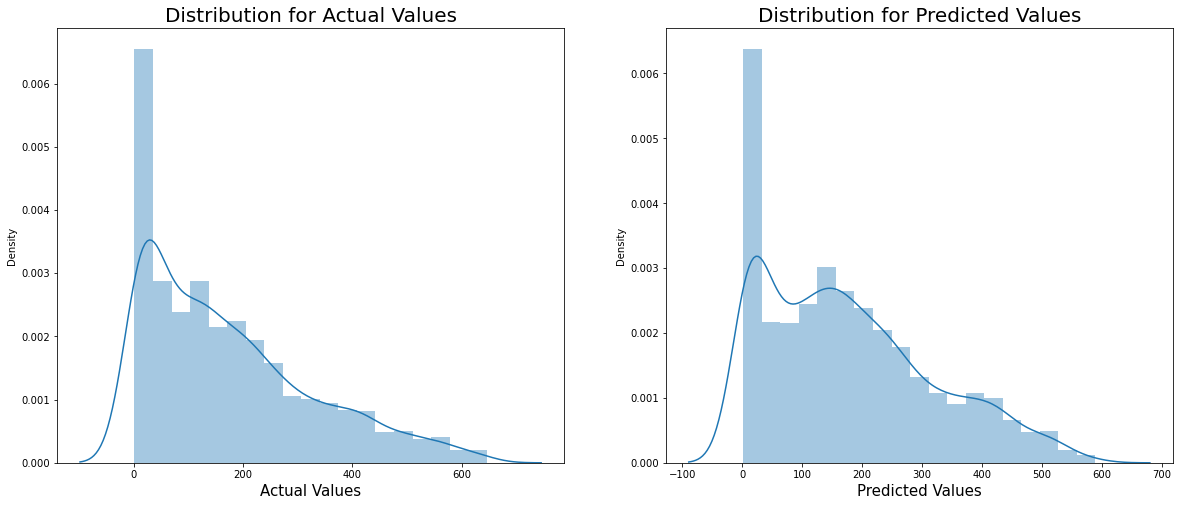

In [42]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title("Distribution for Actual Values", fontsize=20)
sns.distplot(y_test, ax=ax[0])
ax[0].set_xlabel("Actual Values", fontsize=15)

ax[1].set_title("Distribution for Predicted Values", fontsize=20)
sns.distplot(y_preds_app2, ax=ax[1])
ax[1].set_xlabel("Predicted Values", fontsize=15)

plt.show()

### We can confirm visually that our predictions are really close to the actual values and our model performed really well.

<a id='16'></a>
### 4.3.2 Save model

In [43]:
pickle.dump(best_model_app2, open('model_approach_2.pkl', 'wb'))

<a id='17'></a>
### 4.3.3 Prediction + Submission (for Kaggle only)

In [ ]:
# predict on test data
X_test = test_df[selected_features]
y_preds = best_model_app_2.predict(X_test)

# convert to dataframe
y_preds_df = pd.DataFrame({'count' : y_preds})

# Extract datetime column values in a dataframe
datetime_df = pd.DataFrame(pd.read_csv('../input/bike-demand-processed-data/test.csv')['datetime'])

# Combine the 2 dataframes
subm = pd.concat([datetime_df, y_preds_df], axis=1)
subm.head()

# Convert to csv file
subm.to_csv('sampleSubmission.csv', index=False)